In [1]:
# Install dependencies if needed
!pip install librosa tensorflow -q

import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# --------------------
# 1. Hyperparameters & Configuration
# --------------------
SAMPLE_RATE = 44100          # All audio resampled to 16 kHz
WINDOW_LENGTH = 3.0          # Window duration in seconds (fixed size)
HOP_LENGTH_SEC = 0.75         # Overlap: 50% (adjust as needed)
N_MFCC = 13                  # Number of MFCC coefficients
N_FFT = 1024                 # FFT window size
HOP_LENGTH = 256             # Hop length for MFCC computation

# Data augmentation settings (optional)
TIME_STRETCH_FACTORS = [0.9, 1.1]  # ±10% speed
PITCH_SHIFT_STEPS = [-2, 2]        # ±2 semitones

# Training settings
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 10

# Dysarthria severity classes: 0->VERY LOW, 1->LOW, 2->MEDIUM, 3->HIGH
NUM_CLASSES = 4
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# --------------------
# 2. Speaker-to-Severity Mapping
# --------------------
speaker_id_to_label = {
    "F05": 0,  # VERY LOW
    "M08": 0,
    "M09": 0,
    "M10": 0,
    "M14": 0,
    "F04": 1,  # LOW
    "M05": 1,
    "M11": 1,
    "F02": 2,  # MEDIUM
    "M07": 2,
    "M16": 2,
    "M01": 3,  # HIGH
    "F03": 3,
    "M12": 3,
    "M04": 3
}

In [4]:
# --------------------
# 3. Fixed-Size Window Segmentation
# --------------------
def segment_audio_into_windows(audio_array, sr, window_length, hop_length_sec):
    """
    Segments an audio waveform into fixed-size windows.
    If the audio is shorter than the window, pad with zeros.
    """
    total_samples = len(audio_array)
    window_samples = int(window_length * sr)
    hop_samples = int(hop_length_sec * sr)

    # Pad audio if it's shorter than window size
    if total_samples < window_samples:
        audio_array = np.pad(audio_array, (0, window_samples - total_samples), mode='constant')

    # Generate overlapping windows
    windows = [audio_array[i : i + window_samples] for i in range(0, total_samples - window_samples + 1, hop_samples)]
    return windows

In [5]:
# --------------------
# 4. Data Augmentation (Optional)
# --------------------
def augment_audio(audio, sr=SAMPLE_RATE):
    """
    Apply time stretching and pitch shifting to a given audio segment.
    Returns a list including the original and augmented versions.
    """
    augmented_signals = [audio]  # Original signal

    for factor in TIME_STRETCH_FACTORS:
        stretched = librosa.effects.time_stretch(audio, rate=factor)
        augmented_signals.append(stretched)
    
    for steps in PITCH_SHIFT_STEPS:
        pitched = librosa.effects.pitch_shift(audio, sr=44100, n_steps=steps)
        augmented_signals.append(pitched)
    
    return augmented_signals

In [6]:
# --------------------
# 5. MFCC Feature Extraction
# --------------------
def extract_mfcc(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extract MFCC features from a fixed-length audio segment.
    Returns a 2D array with shape (n_mfcc, time_frames).
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

In [9]:
import os
import numpy as np
import torch
import torchaudio
from tqdm import tqdm

# Dataset directory
DATASET_DIR = "/kaggle/input/class-data/class-data"
SEVERITY_LEVELS = ["VERY LOW", "LOW", "MEDIUM", "HIGH"]
SAMPLE_RATE = 16000  # Adjust if needed
WINDOW_LENGTH = 3.0  # in seconds
HOP_LENGTH_SEC = 0.75  # in seconds

def segment_audio_into_windows(waveform, sr, window_length, hop_length_sec):
    """Splits audio into overlapping windows and ensures all windows are exactly of fixed length."""
    window_size = int(window_length * sr)
    hop_size = int(hop_length_sec * sr)
    windows = [waveform[i:i + window_size] for i in range(0, len(waveform) - hop_size + 1, hop_size)]
    
    # Ensure all windows are exactly `window_size` long by padding
    for i in range(len(windows)):
        if len(windows[i]) < window_size:
            pad_length = window_size - len(windows[i])
            windows[i] = np.pad(windows[i], (0, pad_length), mode='constant')
    
    return windows

def process_file(file_path, label):
    """Loads and processes an audio file."""
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(waveform)
    waveform = waveform.numpy().squeeze()
    windows = segment_audio_into_windows(waveform, sr=SAMPLE_RATE, window_length=WINDOW_LENGTH, hop_length_sec=HOP_LENGTH_SEC)
    
    mfcc_list, label_list = [], []
    for window in windows:
        tensor_variant = torch.tensor(window).unsqueeze(0)
        mfcc_feat = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=13, log_mels=True)(tensor_variant)
        mfcc_feat = mfcc_feat.squeeze(0).numpy()
        mfcc_list.append(mfcc_feat)
        label_list.append(label)
    
    return mfcc_list, label_list

def load_and_process_dataset():
    """Loads and processes all audio files from the severity folders."""
    file_paths, labels = [], []
    for severity in SEVERITY_LEVELS:
        severity_folder = os.path.join(DATASET_DIR, severity)
        if not os.path.isdir(severity_folder):
            continue
        for wav_file in os.listdir(severity_folder):
            if wav_file.lower().endswith(".wav"):
                file_paths.append(os.path.join(severity_folder, wav_file))
                labels.append(severity)
    print("File paths: ",len(file_paths), "\nLabels: ",len(labels))
    
    X, y = [], []
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc="Processing files"):
        mfcc_list, label_list = process_file(file_path, label)
        X.extend(mfcc_list)
        y.extend(label_list)
    
    print(f"Dataset loaded with {len(X)} samples")
    return np.array(X, dtype=np.float32), np.array(y)

# Run data loading
X, y = load_and_process_dataset()
print("Dataset shape:", X.shape, "Labels shape:", y.shape)

File paths:  11437 
Labels:  11437


Processing files:   0%|          | 0/11437 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Processing files: 100%|██████████| 11437/11437 [03:59<00:00, 47.66it/s]


Dataset loaded with 45191 samples
Dataset shape: (45191, 13, 241) Labels shape: (45191,)


In [10]:
# --------------------
# 7. Data Splitting and Label Encoding
# --------------------
def train_val_test_split(X, y, test_size=0.3, random_state=SEED):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def one_hot_encode_labels(labels, num_classes=NUM_CLASSES):
    return to_categorical(labels, num_classes=num_classes)

In [11]:
# --------------------
# 8. Model: CNN + Transformer (EmoFormer-Style)
# --------------------
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
    
    def call(self, inputs, training=False):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_emoformer_model(input_shape, num_classes=NUM_CLASSES,
                          cnn_filters=[16, 32, 64, 64],
                          cnn_kernel_sizes=[(5,5), (3,3), (3,3), (3,3)],
                          pool_size=(2,2),
                          transformer_embed_dim=64,
                          transformer_ffn_dim=128,
                          transformer_heads=8,
                          transformer_blocks=1,
                          dropout_rate=0.2):
    """
    Build the CNN + Transformer model.
    The input_shape is expected to be (n_mfcc, time_frames, 1).
    """
    inputs = keras.Input(shape=input_shape)
    
    x = inputs
    for i, f in enumerate(cnn_filters):
        x = layers.Conv2D(filters=f, kernel_size=cnn_kernel_sizes[i],
                          activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        if i < 3:
            x = layers.MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(transformer_embed_dim, activation='relu')(x)
    
    # Reshape for transformer (batch, seq_len, embed_dim). Here we use seq_len = 1.
    x = layers.Reshape((1, transformer_embed_dim))(x)
    for _ in range(transformer_blocks):
        x = TransformerEncoder(embed_dim=transformer_embed_dim,
                               dense_dim=transformer_ffn_dim,
                               num_heads=transformer_heads,
                               dropout=dropout_rate)(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name="Dysarthria_EmoFormer")
    return model

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define severity levels (ensuring order is consistent)
SEVERITY_LEVELS = ["VERY LOW", "LOW", "MEDIUM", "HIGH"]

# Encode labels as numerical indices
label_encoder = LabelEncoder()
label_encoder.fit(SEVERITY_LEVELS)

y_encoded = label_encoder.transform(y)  # Convert labels to integers

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Convert to one-hot encoding
y_train_oh = to_categorical(y_train, num_classes=len(SEVERITY_LEVELS))
y_test_oh = to_categorical(y_test, num_classes=len(SEVERITY_LEVELS))

print("One-hot encoded labels shape:", y_train_oh.shape, y_test_oh.shape)

One-hot encoded labels shape: (31633, 4) (13558, 4)


In [15]:
# Determine input shape from data
_, n_mfcc, time_frames,= X.shape
model = build_emoformer_model(input_shape=(n_mfcc, time_frames, 1),
                              num_classes=NUM_CLASSES,
                              transformer_embed_dim=64,
                              transformer_ffn_dim=128,
                              transformer_heads=8,
                              transformer_blocks=1,
                              dropout_rate=0.2)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=PATIENCE,
                                               restore_best_weights=True)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "Dysarthria_EmoFormer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13, 241, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 13, 241, 16)         │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 241, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 6, 120, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 120, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 120, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 60, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 60, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 60, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 30, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 30, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 30, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 1, 64)               │         149,504 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 215,108 (840.27 KB)

 Trainable params: 214,756 (838.89 KB)

 Non-trainable params: 352 (1.38 KB)

In [16]:
# Train the model
history = model.fit(X_train, y_train_oh,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6458 - loss: 0.8662 - val_accuracy: 0.7247 - val_loss: 0.6390
Epoch 2/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8089 - loss: 0.5082 - val_accuracy: 0.7640 - val_loss: 0.5991
Epoch 3/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8494 - loss: 0.4043 - val_accuracy: 0.8614 - val_loss: 0.3740
Epoch 4/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8730 - loss: 0.3421 - val_accuracy: 0.8581 - val_loss: 0.3976
Epoch 5/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8903 - loss: 0.2877 - val_accuracy: 0.8774 - val_loss: 0.3328
Epoch 6/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9028 - loss: 0.2558 - val_accuracy: 0.8530 - val_loss: 0.4234
Epoch 7/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9181 - loss: 0.2239 - val_accuracy: 0.8805 - val_loss: 0.3386
Epoch 8/50
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9208 - loss: 0.2086 -

In [18]:
model.save("dysarthria_emoformer_model.h5")

In [19]:
# Save the entire model (architecture + weights)
model.save("dysarthria_emoformer.h5")

In [20]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Compute additional metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall    = recall_score(y_test, y_pred, average='macro')
f1        = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Test Accuracy: 0.9438


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Precision: 0.9453
Recall:    0.9406
F1-score:  0.9427


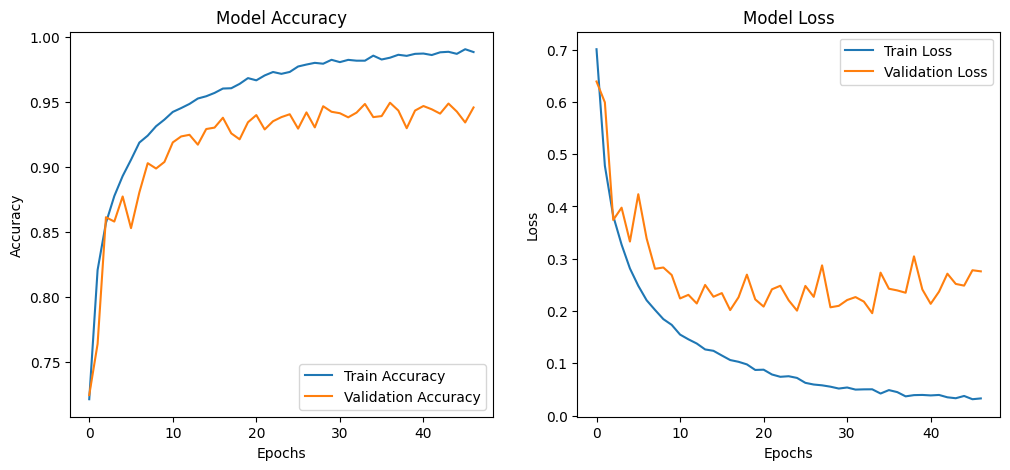

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

    VERY LOW       0.94      0.96      0.95      4908
         LOW       0.97      0.92      0.94      2624
      MEDIUM       0.93      0.95      0.94      2679
        HIGH       0.94      0.93      0.94      3347

    accuracy                           0.94     13558
   macro avg       0.95      0.94      0.94     13558
weighted avg       0.94      0.94      0.94     13558



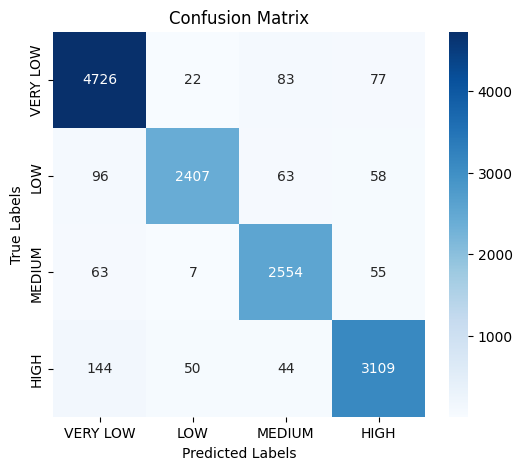

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_oh, axis=1)  # Convert one-hot encoding back to class labels

# Classification Report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=SEVERITY_LEVELS))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=SEVERITY_LEVELS, yticklabels=SEVERITY_LEVELS)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

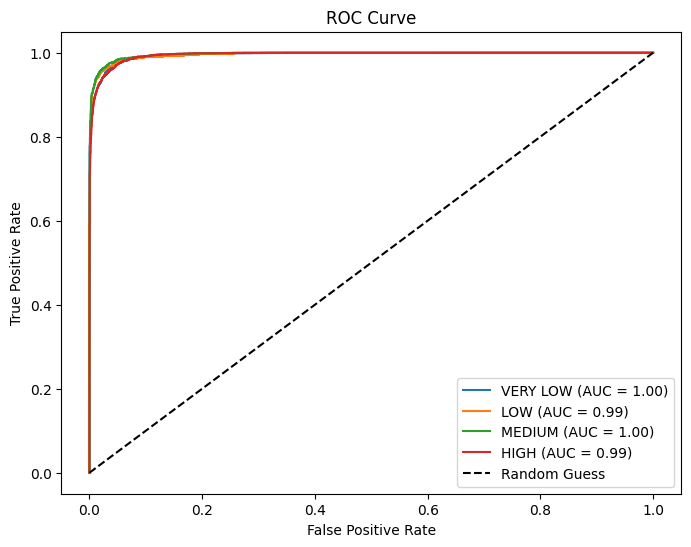

In [23]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for i, severity in enumerate(SEVERITY_LEVELS):
    fpr, tpr, _ = roc_curve(y_test_oh[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{severity} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

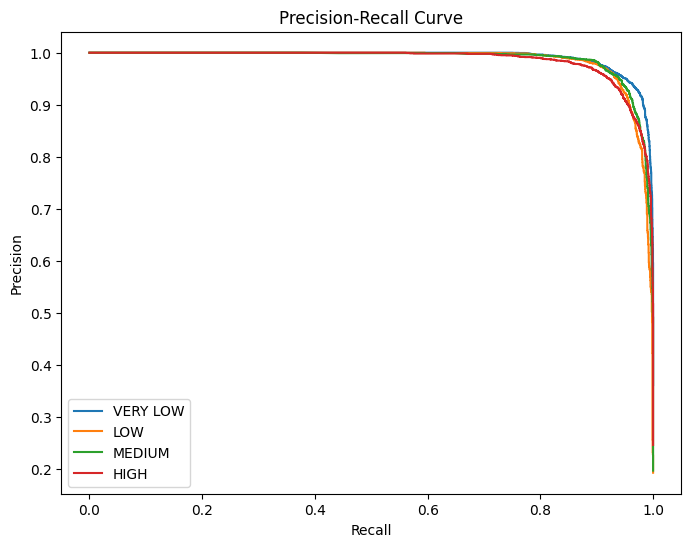

In [24]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

for i, severity in enumerate(SEVERITY_LEVELS):
    precision, recall, _ = precision_recall_curve(y_test_oh[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'{severity}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

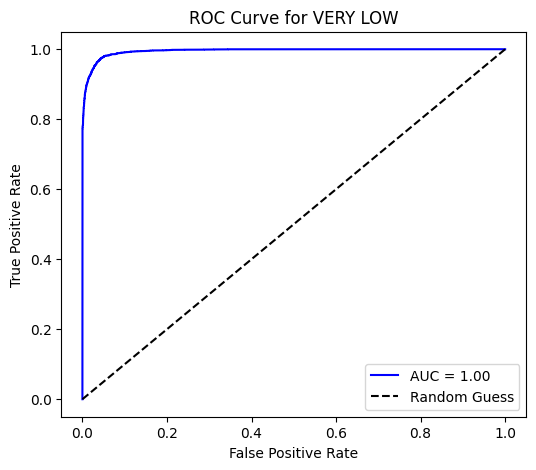

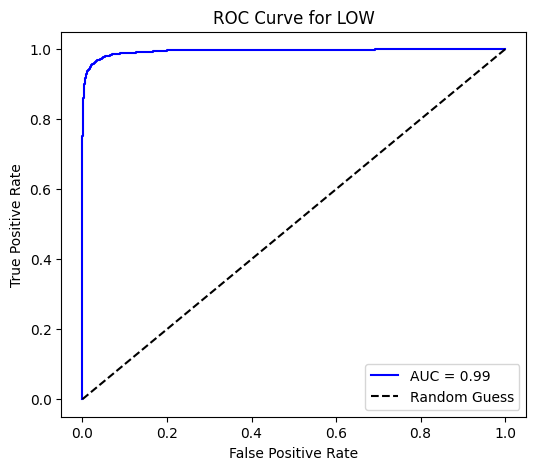

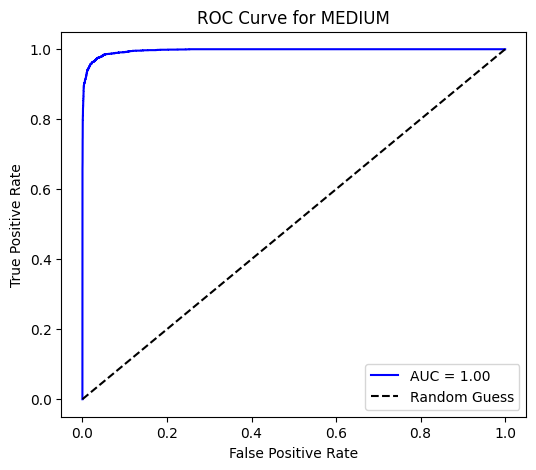

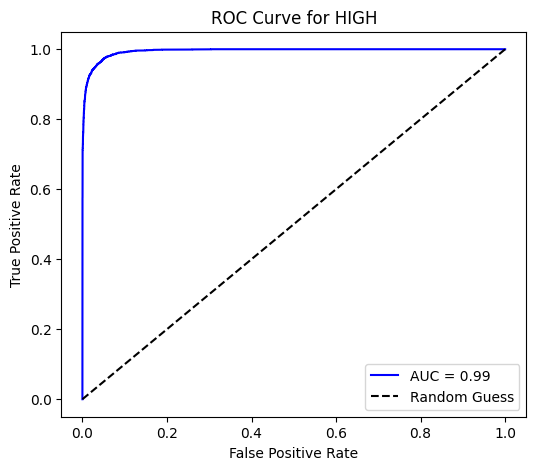

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for i, severity in enumerate(SEVERITY_LEVELS):
    plt.figure(figsize=(6, 5))
    fpr, tpr, _ = roc_curve(y_test_oh[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {severity}')
    plt.legend()
    plt.show()

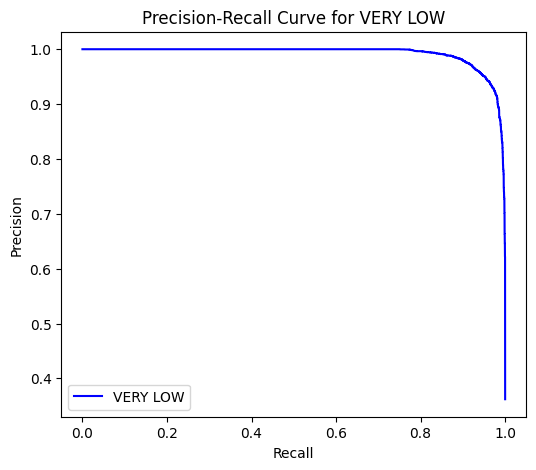

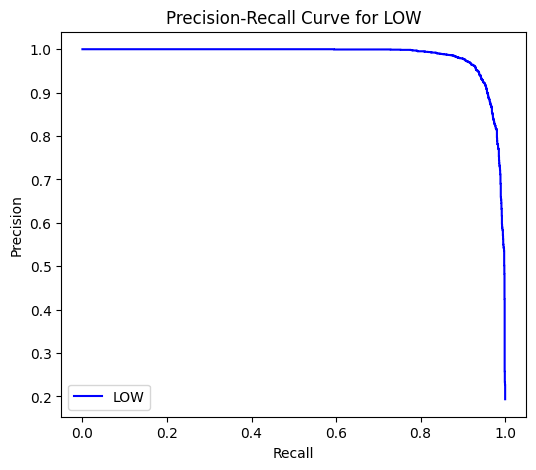

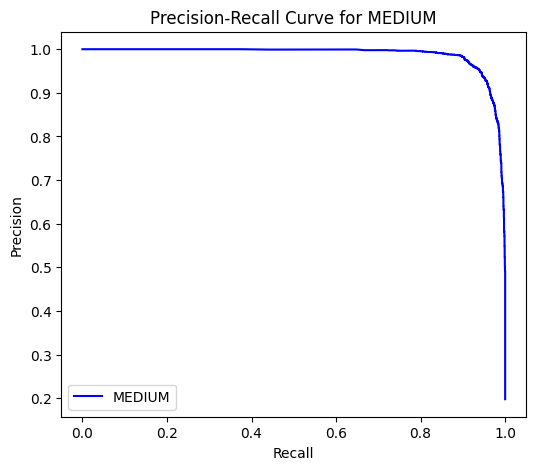

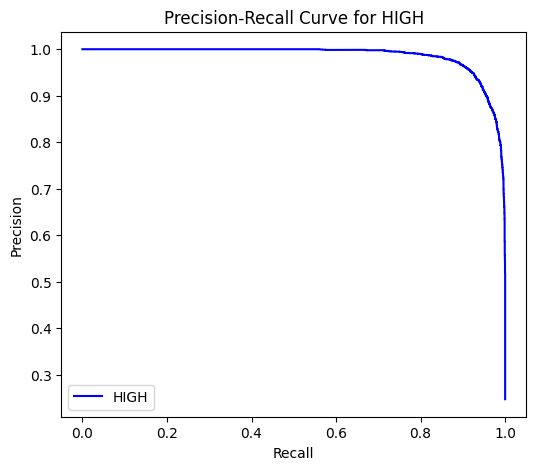

In [26]:
from sklearn.metrics import precision_recall_curve

for i, severity in enumerate(SEVERITY_LEVELS):
    plt.figure(figsize=(6, 5))
    precision, recall, _ = precision_recall_curve(y_test_oh[:, i], y_pred[:, i])

    plt.plot(recall, precision, color='blue', label=f'{severity}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {severity}')
    plt.legend()
    plt.show()